In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Data Sample Load

Load [titanic](https://gist.github.com/michhar/2dfd2de0d4f8727f873422c5d959fff5) dataset.

In [2]:
# Load dataset with pandas.DataFrame()

#data = pd.read_csv('titanic.csv')
data = pd.read_csv('https://grantmlong.com/data/titanic.csv')

In [3]:
data.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


# Data Preprocessing

In [4]:
def data_preprocessing(data_input):
    
    # Select bad columns and remove them
    cols_2_drop = ['PassengerId', 'Ticket', 'Cabin', 'Name']
    data_input = data_input.drop(cols_2_drop, axis=1)
    
    # Replace missing values (NaN) with -999 for 'Age' feature
    data_input.loc[:, 'Age'] = data_input.Age.fillna(-999)
    
    # Encode 'Sex' values
    data_input.loc[:, 'Sex'] = data_input.Sex.replace({'male': 0, 'female': 1})
    
    # Remove all object with missing values
    data_input = data_input.dropna()
    
    # Encode categorical features using OneHotEncoding
    data_input = pd.get_dummies(data_input, columns=['Embarked'], prefix_sep='=')
    
    return data_input

In [5]:
data_preproc = data_preprocessing(data)

In [6]:
data_preproc.head()

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked=C,Embarked=Q,Embarked=S
0,0,3,0,22.0,1,0,7.2500,0,0,1
1,1,1,1,38.0,1,0,71.2833,1,0,0
2,1,3,1,26.0,0,0,7.9250,0,0,1
3,1,1,1,35.0,1,0,53.1000,0,0,1
4,0,3,0,35.0,0,0,8.0500,0,0,1


# Data Study

Let's loot at the data to get better understanding of its properties.

In [7]:
# Set up label column
y_column = "Survived"

# Select X columns
X_columns = data_preproc.columns[data_preproc.columns != y_column]

X_columns

Index(['Pclass', 'Sex', 'Age', 'SibSp', 'Parch', 'Fare', 'Embarked=C',
       'Embarked=Q', 'Embarked=S'],
      dtype='object')

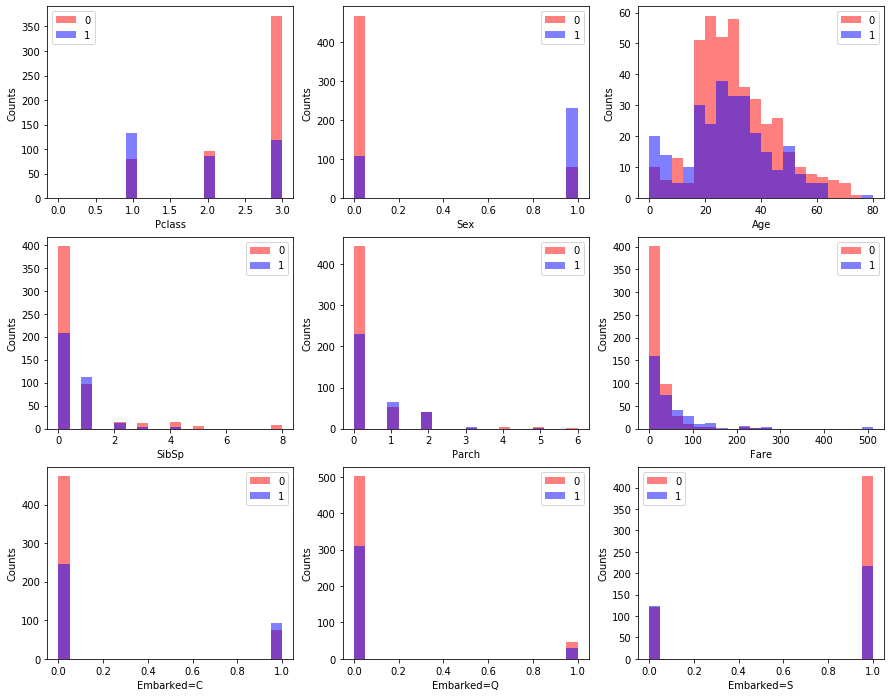

In [8]:
# Define size of the figure
plt.figure(figsize=(15, 12))

# For each column ...
for i_col in range(len(X_columns)):
    
    # Create subplot for each column
    plt.subplot(3, 3, i_col+1)
    
    # Get column and label values
    x_col = data_preproc[X_columns[i_col]].values
    y_col = data_preproc[y_column].values
    
    # Plot histograms
    bins = np.linspace(0, x_col.max(), 21)
    plt.hist(x_col[y_col == 0], bins=bins, color='r', alpha=0.5, label='0')
    plt.hist(x_col[y_col == 1], bins=bins, color='b', alpha=0.5, label='1')
    
    # Labels and legend
    plt.xlabel(X_columns[i_col])
    plt.ylabel('Counts')
    plt.legend(loc='best')
    
plt.show()

# Create Matrix X

Create a maxtrix with objects $X$ and vector of the object labels $y$.
<table><tr>
<td> <img src="img/known_all_object.png" width="250"> </td>
<td> <img src="img/known_all_feature.png" width="250"> </td>
</tr></table>

In [9]:
X = data_preproc[X_columns].values
y = data_preproc[y_column].values

## Data Split

We split data into **train** and **test** samples. Train sample is used to train the DT. Test sample is used to measure quality of the classifier. 

<img src="img/train_test_object.png" width="250">

To do this we use `train_test_split` function from the scikit-learn library.

In [10]:
# import train_test_split function to split the sample
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size=0.5,    # 20% for test, 80% for train
                                                    random_state=123) # shuffle objects before split

# Decision Tree Classifier

Consider Decision Tree Classifier algorithm. 

<table><tr>
<td> <img src="img/dt2.png" width="600"> </td>
<td> <img src="img/dt1.png" width="400"> </td>
</tr></table>

Decision tree building is started from the root node. The selection rule is estimated to maximize **information gain** for the node plit:

$$
\Delta I_{node} = I_{node} - (I_{left} \frac{N_{left}}{N_{node}} + I_{right} \frac{N_{right}}{N_{node}})
$$

where $I_{node}$ is impurity of a node. Popular impurity functions are:

**Gini**

$$
I_{node} = \sum_{i}^{C}p_{i}(1 - p_{i})
$$

**Entropy**

$$
I_{node} = -\sum_{i}^{C}p_{i}log(p_{i})
$$

**Classification error**

$$
I_{node} = 1 - \max_{i}p_{i}
$$

where $p_{i}$ is fraction of objects of class $i$ in the node:

$$
p_{i} = \frac{N_{i}}{\sum_{i}^{C}N_{i}}
$$

Let's look at the example:

<img src="img/split.png" width="800">

In [11]:
class Node(object):
    
    def __init__(self):
        """
        Class for a decision tree node.
        """
        
        self.right = None
        self.left = None
        
        self.threshold = None
        self.column = None
        
        self.depth = None
        self.probas = None
        
        self.informative = None
        self.is_terminal = False

In [12]:
class DecisionTreeClassifier(object):
    
    def __init__(self, max_depth=3, min_samples_leaf=1, min_samples_split=2, impurity='gini'):
        """
        Class for a Decision Tree Classifier.
        
        Parameters
        ----------
        max_depth : int
            Max depth of a decision tree.
        min_samples_leaf : int
            Minimal number of samples (objects) in a leaf (terminal node).
        min_samples_split : int
            Minimal number of samples (objects) in a node to make a split.
        impurity : str
            Impurity function used for the decision tree building.
        """
        
        # Make hyperparameters visible inside the class
        self.max_depth = max_depth
        self.min_samples_leaf = min_samples_leaf
        self.min_samples_split = min_samples_split
        self.impurity = impurity
        
        # Object for the decision tree
        self.Tree = None
        
        # Helping objects
        self.classes = []
        
    def get_params(self, deep=True):
        """
        Returns class parameters.

        Parameters
        ----------
        deep : boolean
            If True, will return the parameters for this estimator and contained subobjects that are estimators.

        Returns
        -------
        params : dict
            Parameters of the class.
        """

        params = {'max_depth': self.max_depth,
                  'min_samples_leaf': self.min_samples_leaf,
                  'min_samples_split': self.min_samples_split,
                  'impurity': self.impurity}

        return params
    
    
    def set_params(self, **params):
        """
        Set class parameters.

        Parameters
        ----------
        params : dict
            Dictionary of the class parameters.
        """

        for key, value in params.items():
            setattr(self, key, value)

        return self

        
    
    def node_probabilities(self, y):
        """
        Estimate probabilities of classes in data.
        
        Parameters
        ----------
        y : numpy.array, shape = (n_objects)
            1D array with the object labels. 
            For the classification labels are integers in {0, 1, 2, ...}.
            
        Returns
        -------
        probas : numpy.array, shape = (n_objects, n_classes)
            2D array with predicted probabilities of each class. 
            Example:
                y_predicted_proba = [[0.1, 0.9],
                                     [0.8, 0.2], 
                                     [0.0, 1.0], 
                                     ...]
        """
        
        # To store probas
        probas = []
        
        # For each class in data ...
        for one_class in self.classes:
            
            # Estimate probability of the class
            class_proba = 1. * (y == one_class).sum() / len(y)
            # class_proba = 0.8 (example)
            
            # Store the probability
            probas.append(class_proba)
        
        return probas
    
    
    def gini_calculation(self, probas):
        """
        Calculate gini value.
        
        Parameters
        ----------
        probas : numpy.array, shape = (n_objects, n_classes)
            2D array with predicted probabilities of each class. 
            Example:
                probas = [0.1, 0.9]
            
        Returns
        -------
        gini : float
            Gini value.
        """
        
        gini = 1
        for p in probas:
            gini -= p**2
        
        return gini
    
    
    def impurity_calculation(self, y):
        """
        Calculate data impurity.
        
        Parameters
        ----------
        y : numpy.array, shape = (n_objects)
            1D array with the object labels. 
            For the classification labels are integers in {0, 1, 2, ...}.
            
        Returns
        -------
        impurity : float
            Impuroty of the data.
        """
                
        # Estimate probabilities for each class
        probas = self.node_probabilities(y)
        # probas = [0.90, 0.10] (example)
        
        # Calculate impurity of the data
        if self.impurity == 'gini':
            impurity = self.gini_calculation(probas)
            # impurity = 0.6 (example)
        
        return impurity
        
    
    def best_split(self, X, y):
        """
        Make the best split of data in a decision tree node.
        
        Parameters
        ----------
        X : numpy.array, shape = (n_objects, n_features)
            Matrix of objects that are described by their input features.
        y : numpy.array, shape = (n_objects)
            1D array with the object labels. 
            For the classification labels are integers in {0, 1, 2, ...}.
            
        Returns
        -------
        best_split_column : int
            Index of the best split column
        best_threshold : float
            The best split condition.
        X_left : numpy.array, shape = (n_objects, n_features)
            Matrix of objects in the left child that are described by their input features.
        y_left : numpy.array, shape = (n_objects)
            1D array with the object labels in the left child. 
            For the classification labels are integers in {0, 1, 2, ...}.
        X_right : numpy.array, shape = (n_objects, n_features)
            Matrix of objects in the right child that are described by their input features.
        y_right : numpy.array, shape = (n_objects)
            1D array with labels of the objects in the right child. 
            For the classification labels are integers in {0, 1, 2, ...}.
        """
        
        # To store best split parameters
        best_split_column = None
        best_threshold = None
        best_information_gain = -999
        
        # Data impurity before the split
        impurity = self.impurity_calculation(y)
        # impurity = 0.8 (example)
        
        # For each column in X ...
        for split_column in range(X.shape[1]):
            
            # Select values of the column
            x_col = X[:, split_column]
            # x_col = [2.6, 1.3, 0.5, ...] (example)
            
            # For each value in the column ...
            for i_x in range(0, len(x_col)):
                
                # Take the value as a threshold for a split
                threshold = x_col[i_x]
                # threshold = 1.3 (example)
                
                # Make the split into right and left childs
                y_right = y[x_col > threshold]
                y_left = y[x_col <= threshold]
                # y_left = [0, 1, 1, 0, 1] (example)
                
                if len(y_right) == 0 or len(y_left) == 0:
                    continue
                
                # Calculate impurity for each child
                impurity_left = self.impurity_calculation(y_left)
                impurity_right = self.impurity_calculation(y_right)
                # impurity_right = 0.6 (example)
                
                # Calculate information gain of the split
                information_gain = impurity
                information_gain -= impurity_left * len(y_left) / len(y)
                information_gain -= impurity_right * len(y_right) / len(y)
                # information_gain = 0.2 (example)
                
                # Is this information_gain the best?
                if information_gain > best_information_gain:
                    best_split_column = split_column
                    best_threshold = threshold
                    best_information_gain = information_gain
                    
        # If no split available
        if best_information_gain == -999:
            return None, None, None, None, None, None, None
        
        # Take the best split parameters and make this split
        x_col = X[:, best_split_column]
        X_left = X[x_col <= best_threshold, :]
        y_left = y[x_col <= best_threshold]
        X_right = X[x_col > best_threshold, :]
        y_right = y[x_col > best_threshold]
        
        return best_split_column, best_threshold, X_left, y_left, X_right, y_right, best_information_gain
                    
                
    
    def decision_tree(self, node, X, y):
        """
        Functions builds a decision tree.
        
        Parameters
        ----------
        node : Node() object
            Current node of the decision tree.
        X : numpy.array, shape = (n_objects, n_features)
            Matrix of objects that are described by their input features.
        y : numpy.array, shape = (n_objects)
            1D array with the object labels. 
            For the classification labels are integers in {0, 1, 2, ...}.
        """
        
        # Check termination conditions
        if node.depth >= self.max_depth:      # max_depth check
            node.is_terminal = True
            return
        if len(X) < self.min_samples_split:   # min_samples_split check
            node.is_terminal = True
            return
        if len(np.unique(y)) == 1:
            node.is_terminal = True
            return
        
        # Make best split
        split_column, threshold, X_left, y_left, X_right, y_right, best_information_gain = self.best_split(X, y) # Make a split
        # split_column = 2 (exmaple) column index of the split
        # threshold = 2.74 (example) split_column > threshold
        
        # Check additional termination conditions
        if split_column is None:
            node.is_terminal = True
            return
        if len(X_left) < self.min_samples_leaf or len(X_right) < self.min_samples_leaf:  # min_samples_leaf check
            node.is_terminal = True
            return
        
        
        # Add split parameters into the current node
        node.column = split_column
        node.threshold = threshold
        node.informative = best_information_gain * len(X)
        
        # Create a left child of the current node
        node.left = Node()
        node.left.depth = node.depth + 1
        node.left.probas = self.node_probabilities(y_left)
        
        # Create a right child of the current node
        node.right = Node()
        node.right.depth = node.depth + 1
        node.right.probas = self.node_probabilities(y_right)
        
        # Make splits for the left and right nodes
        self.decision_tree(node.right, X_right, y_right)
        self.decision_tree(node.left, X_left, y_left)
        
    
    def fit(self, X, y):
        """
        Fit the Decision Tree Classifier.
        
        Parameters
        ----------
        X : numpy.array, shape = (n_objects, n_features)
            Matrix of objects that are described by their input features.
        y : numpy.array, shape = (n_objects)
            1D array with the object labels. 
            For the classification labels are integers in {0, 1, 2, ...}.
        """
        
        # Get unique class labels
        self.classes = np.unique(y)
        # self.classes = [0, 1] (example)
        
        # Create a root node of a decision tree
        self.Tree = Node()                             # Create an empty node
        self.Tree.depth = 1                            # the node depth
        self.Tree.probas = self.node_probabilities(y)  # init class probabilities
        
        # Build the decision tree
        self.decision_tree(self.Tree, X, y)
        
    
    def one_prediction(self, node, x):
        """
        Functions builds a decision tree.
        
        Parameters
        ----------
        node : Node() object
            Current node of the decision tree.
        x : numpy.array, shape = (n_features,)
            Array of feature values of one object.
        """
        
        # Termination condition
        if node.is_terminal == True:     # If it is a leaf (terminal node, no childs)
            return node.probas                           # Return probas of the terminal node
            # node.probas = [0.9, 0.1] (example)
        
        # Run to the current node's childs
        # Check split condition. If yes, go to the right child
        if x[node.column] > node.threshold:
            # Right child
            probas = self.one_prediction(node.right, x)
            # probas = [0.9, 0.1] (example)
        else: 
            # Left child
            probas = self.one_prediction(node.left, x)
            # probas = [0.9, 0.1] (example)
            
        return probas
    
    
    def predict_proba(self, X):
        """
        Predict class probabilities for unknown objects.
        
        Parameters
        ----------
        X : numpy.array, shape = (n_objects, n_features)
            Matrix of objects that are described by their input features.
            
        Returns
        -------
        y_predicted_proba : numpy.array, shape = (n_objects, n_classes)
            2D array with predicted probabilities of each class. 
            Example:
                y_predicted_proba = [[0.1, 0.9],
                                     [0.8, 0.2], 
                                     [0.0, 1.0], 
                                     ...]
        """
        
        # Create an empty list for predicted probabilities
        y_predicted_proba = []
        
        # For each object in X make a prediction
        for one_x in X:
            
            # Make the prediction for one object 
            one_proba = self.one_prediction(self.Tree, one_x)
            # one_proba = [0.9, 0.1] (example)
            
            # Store the predictions
            y_predicted_proba.append(one_proba)
        
        return np.array(y_predicted_proba)
    
    
    def predict(self, X):
        """
        This methods performs labels prediction for new objects.
        
        Parameters
        ----------
        X : numpy.array, shape = (n_objects, n_features)
            Matrix of objects that are described by their input features.
            
        Returns
        -------
        y_predicted : numpy.array, shape = (n_objects)
            1D array with predicted labels. 
            For the classification labels are integers in {0, 1, 2, ...}.
        """
        
        # Predict probabilities
        y_predicted_proba = self.predict_proba(X)
        # y_predicted_proba = [[0.90, 0.10], 
        #                      [0.23, 0.77], 
        #                       ...]  (example)
        
        # Find class labels with the highest probability
        y_predicted = y_predicted_proba.argmax(axis=1)
        # y_predicted = [0, 1] (example)
        
        return y_predicted
    
    def features_importance_(self):
        
        features_importance_dict = {}
        root = self.Tree
        stack = [root]
        while len(stack):
            node = stack.pop()
            if node.column in features_importance_dict:
                features_importance_dict[node.column] += node.informative
            else:
                features_importance_dict[node.column] = node.informative
            if node.left.informative:
                stack.append(node.left)
            if node.right.informative:
                stack.append(node.right)
        return features_importance_dict

In [13]:
%time
clf = DecisionTreeClassifier(max_depth=20, min_samples_leaf=1, min_samples_split=2, impurity='gini')
clf.fit(X_train, y_train)
y_test_predict = clf.predict(X_test)

CPU times: user 2 µs, sys: 0 ns, total: 2 µs
Wall time: 4.77 µs


In [14]:
feat_importance = clf.features_importance_()
max_ = np.max(list(feat_importance.values()))
for name in list(feat_importance.keys()):
    value = feat_importance[name]
    feat_importance[name] = value/max_
feat_importance

{1: 1.0,
 0: 0.23200459984697064,
 5: 0.7437159979681524,
 3: 0.1394743685199466,
 2: 0.7661560463726466,
 4: 0.15325848118259022,
 8: 0.026320924940429348,
 6: 0.03244332958671074}

In [15]:
from sklearn.tree import DecisionTreeClassifier
clf_sk = DecisionTreeClassifier(max_depth=20, min_samples_leaf=1, min_samples_split=2, criterion='gini')
clf_sk.fit(X_train, y_train)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=20,
                       max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=None, splitter='best')

In [16]:
clf_sk.feature_importances_

array([0.06599673, 0.32327164, 0.21220351, 0.04013839, 0.05614375,
       0.26354456, 0.01567343, 0.00791956, 0.01510844])

In [17]:
y_test_predict[:10]

array([0, 0, 0, 0, 0, 0, 0, 1, 0, 1])

In [18]:
y_test[:10]

array([0, 0, 1, 0, 0, 0, 0, 0, 0, 0])

# Measure Quality of the Classification

Let's measure the quality using **accuracy score**:

$$
\text{Accuracy }(y\_true, y\_predict) = \frac{1}{N} \sum_{i=1}^{N} I(y\_predict_{i} == y\_true_{i})
$$

For the accuracy calculation we use function **accuracy_score** from the scikit-learn library.

In [16]:
# Import accuracy_score function
from sklearn.metrics import accuracy_score

# Calculate accuracy for the test sample
accuracy_test = accuracy_score(y_test, y_test_predict)

print("Test accuracy of DT classifier: ", accuracy_test)

Test accuracy of DT classifier:  0.7325842696629213


# Hyperparameters optimization

Let's find optimal hyperparameters of the Decision Tree Classifier. There several methods how to do this:

<img src="img/optimization.png" width="800">

We will use Grid Search method implemented in `sklearn.model_selection.GridSearchCV` class in `scikit-learn` library.

In [17]:
# Import GridSearchCV class
from sklearn.model_selection import GridSearchCV

# Define Decision Tree classifier with default parameters
clf = DecisionTreeClassifier(max_depth=30, 
                             min_samples_leaf=1, 
                             min_samples_split=2, 
                             impurity='gini')

# Estimate grid of the classifier hyperparameters
parameters = {'max_depth':[1, 3, 5, 7, 9], 
              'min_samples_leaf':[1, 5, 10]}

# Define GridSearch parameters
gs = GridSearchCV(clf,                 # Classifier object to optimize
                  parameters,          # Grid of the hyperparameters
                  scoring='accuracy',  # Claasification quality metric to optimize
                  cv=3)                # Number of folds in KFolds cross-validation (CV)


# Run Grid Search optimization
gs.fit(X_train, y_train)

GridSearchCV(cv=3, error_score='raise-deprecating',
       estimator=<__main__.DecisionTreeClassifier object at 0x1a20501550>,
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'max_depth': [1, 3, 5, 7, 9], 'min_samples_leaf': [1, 5, 10]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='accuracy', verbose=0)

In [18]:
# Get best hyperparameters of the classifier
gs.best_params_

{'max_depth': 7, 'min_samples_leaf': 5}

In [19]:
# Get score (accuracy) of the best model on KFolds CV
gs.best_score_

0.8220720720720721

In [20]:
# Get best model
best_clf = gs.best_estimator_

# Make predictions on our test sample
y_test_predict = best_clf.predict(X_test)

# Calculate accuracy for the test sample
accuracy_test = accuracy_score(y_test, y_test_predict)

print("Test accuracy of DT classifier: ", accuracy_test)

Test accuracy of DT classifier:  0.7842696629213484


In [21]:
# Get full report of the optimization and convert it into pandas.DataFrame
report = pd.DataFrame(data=gs.cv_results_)

# Sort it by mean_test_score column
report.sort_values(by='mean_test_score', ascending=False, inplace=True)

# Show the first 5 rows
report.head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_max_depth,param_min_samples_leaf,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,mean_train_score,std_train_score
10,0.458457,0.062673,0.000655,0.000168,7,5,"{'max_depth': 7, 'min_samples_leaf': 5}",0.844595,0.783784,0.837838,0.822072,0.027214,1,0.854730,0.875000,0.858108,0.862613,0.008867
13,0.462067,0.062157,0.000579,0.000079,9,5,"{'max_depth': 9, 'min_samples_leaf': 5}",0.844595,0.783784,0.837838,0.822072,0.027214,1,0.854730,0.875000,0.858108,0.862613,0.008867
8,0.401220,0.033970,0.000501,0.000034,5,10,"{'max_depth': 5, 'min_samples_leaf': 10}",0.797297,0.777027,0.831081,0.801802,0.022296,3,0.804054,0.861486,0.831081,0.832207,0.023460
9,0.562772,0.012769,0.000936,0.000218,7,1,"{'max_depth': 7, 'min_samples_leaf': 1}",0.810811,0.790541,0.804054,0.801802,0.008427,3,0.905405,0.945946,0.908784,0.920045,0.018367
11,0.422490,0.045955,0.000508,0.000034,7,10,"{'max_depth': 7, 'min_samples_leaf': 10}",0.797297,0.777027,0.831081,0.801802,0.022296,3,0.804054,0.861486,0.831081,0.832207,0.023460


---

## Tasks:

* Implement **Target Encoding** insted of **OneHotEncoder**. Target Encoding is the process of replacing a categorical value with the mean of the target variable. Does it have any differences for the classification?
* How can you modify best split a decision tree node? Is it possible to make it faster? How?

## Questions:

* Is input features scaling important for Decision Tree Classifier?
* Have non-informative (random) features influence on Decision Tree Classifier?

# Decision tree computational complexity

Let 𝑁 = number of training examples, 𝑘 = number of features, and 𝑑 = depth of the decision tree.

Current best_split time is O(N * N * k). This is very uneficient.
We can do better if we sort train examples along each feature. Then we can make split in O(N k). We do split for every level (d - times).
So the time complexity for decision trees is in 𝑂(𝑁𝑘𝑑).
The uncertainty here is due to the non-deterministic way in which decision trees are built, always splitting data based on locally optimal thresholds with close to no consideration for overall balance. Keep in mind building a globally optimal decision tree is an NP-hard problem.

---
---

# Additional Topics

## Underfitting and Overfitting

<img src="img/overfit.jpg" width="600">

Let's consider how the classifier quality depends on **max_depth** value of the classifier. <br/> 
For that, for each **max_depth** value from a range we train the DT classifier and make predictions for the train and test samples. <br/>
Then, we calculate quality metrics for the samples.

In [22]:
depths = np.arange(1,20, 1) # create list of k_neighbors values

# Lists for quality metrics
scores_test = []
scores_train = []

# For each k_neighbors value ...
for max_depth in depths:
    
    # Create a DT classifier object
    clf = DecisionTreeClassifier(max_depth=max_depth, 
                                 min_samples_leaf=1, 
                                 min_samples_split=2, 
                                 impurity='gini')
    
    # Train the classifier (remember, that KNN has no training procedure, but it is a tradition :)
    clf.fit(X_train, y_train)

    # Use the classifier to predict labels
    y_test_predict = clf.predict(X_test)    # predict for the test smaple
    y_train_predict = clf.predict(X_train)  # predict for the train smaple
    
    # Calculate accuracy for the test and train samples
    accuracy_test = accuracy_score(y_test, y_test_predict)    # for the test smaple
    accuracy_train = accuracy_score(y_train, y_train_predict) # for the train smaple 
    
    # Collect scores
    scores_test.append(accuracy_test)
    scores_train.append(accuracy_train)

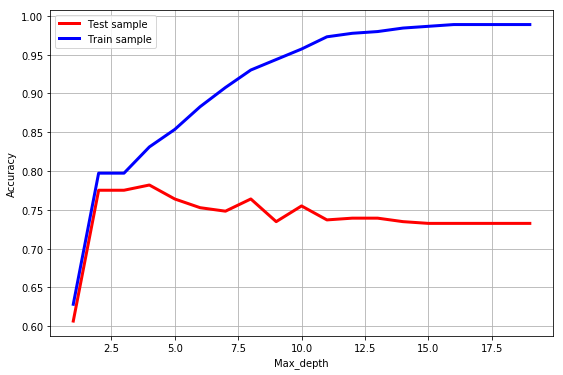

In [23]:
# Create an figure with a custom size
plt.figure(figsize=(9, 6))

# Create the plots
plt.plot(depths, scores_test, color='r', linewidth=3, label='Test sample')
plt.plot(depths, scores_train, color='b', linewidth=3, label='Train sample')

plt.xlabel('Max_depth') # set up X-axis label
plt.ylabel('Accuracy')    # set up Y-axis label

plt.legend(loc='best') # create the plot legend and set up it position
plt.grid(b=1) # create grid on the plot

plt.show() # display the plot

## Plot Decision Surface

Let's prepare two circles data sample to consider decision surface of the Decision Tree classifier.

In [24]:
from sklearn.datasets import make_moons, make_circles # import function from the library

N = 1000

#X, y = make_moons(n_samples=N, noise=0.2, random_state=11) # generate data sample
X, y = make_circles(n_samples=N, noise=0.1, factor=0.6, random_state=1)

In [25]:
# import train_test_split function to split the sample
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size=0.5,    # 20% for test, 80% for train
                                                    random_state=123) # shuffle objects before split

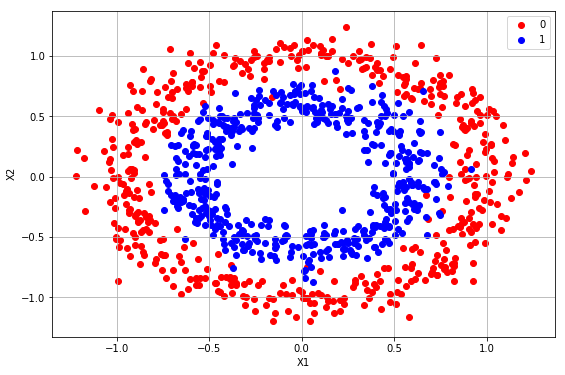

In [26]:
# Create an figure with a custom size
plt.figure(figsize=(9, 6))

# Plot all objects with y == 0 (class 0)
plt.scatter(X[y == 0, 0],     # selects all objects with y == 0 and the 1st column of X
            X[y == 0, 1],     # selects all objects with y == 0 and the 2nd column of X
            color='r',        # points color
            label='0')        # label for the plot legend


# Plot all objects with y == 1 (class 1)
plt.scatter(X[y == 1, 0],     # selects all objects with y == 1 and the 1st column of X
            X[y == 1, 1],     # selects all objects with y == 1 and the 2nd column of X
            color='b',        # points color
            label='1')        # label for the plot legend

plt.xlabel('X1') # set up X-axis label
plt.ylabel('X2') # set up Y-axis label

plt.legend(loc='best') # create the plot legend and set up it position
plt.grid(b=1) # create grid on the plot

plt.show() # display the plot

In [27]:
%time
clf = DecisionTreeClassifier(max_depth=20, min_samples_leaf=1, min_samples_split=2, impurity='gini')
clf.fit(X_train, y_train)
y_test_predict = clf.predict(X_test)

CPU times: user 3 µs, sys: 0 ns, total: 3 µs
Wall time: 8.11 µs


In [28]:
# Import accuracy_score function
from sklearn.metrics import accuracy_score

# Calculate accuracy for the test sample
accuracy_test = accuracy_score(y_test, y_test_predict)

print("Test accuracy of DT classifier: ", accuracy_test)

Test accuracy of DT classifier:  0.916


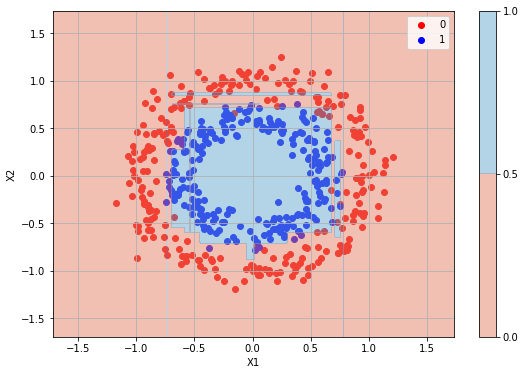

In [29]:
# Create an figure with a custom size
plt.figure(figsize=(9, 6))

# Plot all objects with y == 0 (class 0)
plt.scatter(X_test[y_test == 0, 0],     # selects all objects with y == 0 and the 1st column of X
            X_test[y_test == 0, 1],     # selects all objects with y == 0 and the 2nd column of X
            color='r',                  # points color
            label='0')                  # label for the plot legend


# Plot all objects with y == 1 (class 1)
plt.scatter(X_test[y_test == 1, 0],     # selects all objects with y == 1 and the 1st column of X
            X_test[y_test == 1, 1],     # selects all objects with y == 1 and the 2nd column of X
            color='b',                  # points color
            label='1')                  # label for the plot legend


### THIS IS JUST MAGIC :)

# plot decision boundary
h=0.01
x_min, x_max = X[:, 0].min() - .5, X[:, 0].max() + .5
y_min, y_max = X[:, 1].min() - .5, X[:, 1].max() + .5
xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                     np.arange(y_min, y_max, h))

Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
#Z = clf.predict_proba(np.c_[xx.ravel(), yy.ravel()])[:, 1] # Probas

Z = Z.reshape(xx.shape)

plt.contourf(xx, yy, Z, cmap=plt.cm.RdBu, alpha=.5, levels=1)

### THE END OF THE MAGIC


plt.xlabel('X1') # set up X-axis label
plt.ylabel('X2') # set up Y-axis label

plt.legend(loc='best') # create the plot legend and set up it position
plt.grid(b=1) # create grid on the plot
plt.colorbar()

plt.show() # display the plot

## Features Engineering

How you saw form the previous example, decision trees hardly reconstruct dependencies between input features such as:
* $X_{1} \pm X_{2}$
* $X_{1}X_{2}$
* $X_{1} / X_{2}$
* $X_{1}^{2} \pm X_{2}^{2}$
* ...

Including these new features into the sample can improve calssification quality, especially for Decision Tree Classifier.

In [30]:
# Add square sum of X1 and X2 to train sample
X_train2 = np.c_[X_train, 
                 X_train[:, 0]**2 + X_train[:, 1]**2] # Add square sum

# Add square sum of X1 and X2 to test sample
X_test2 = np.c_[X_test, 
                X_test[:, 0]**2 + X_test[:, 1]**2] # Add square sum

In [31]:
%time

# Fit DT classifier on the new sample
clf = DecisionTreeClassifier(max_depth=10, min_samples_leaf=1, min_samples_split=2, impurity='gini')
clf.fit(X_train2, y_train)

# Make prediction on the new sample
y_test_predict = clf.predict(X_test2)

CPU times: user 3 µs, sys: 1e+03 ns, total: 4 µs
Wall time: 6.2 µs


In [32]:
# Import accuracy_score function
from sklearn.metrics import accuracy_score

# Calculate accuracy for the test sample
accuracy_test = accuracy_score(y_test, y_test_predict)

print("Test accuracy of DT classifier: ", accuracy_test)

Test accuracy of DT classifier:  0.972


### Question:

Is it better now?

# Reduced Error Pruning

"Pruning is a technique in machine learning that reduces the size of decision trees by removing sections of the tree that provide little power to classify instances. Pruning reduces the complexity of the final classifier, and hence improves predictive accuracy by the reduction of overfitting." [wiki](https://en.wikipedia.org/wiki/Decision_tree_pruning)

Reduced Error Pruning procedure:

* Starting form the bottom of a decision tree, remove each subtree. 
* Estimate classification accuracy on a test sample.
* If the test accuracy is better, keep the changes.
* Go to other node of the tree, repeat previous steps.

Example:

<table><tr>
<td> <img src="img/pr1.png" heigh="200"> </td>
<td> <img src="img/pr2.png" heigh="200"> </td>
<td> <img src="img/pr3.png" heigh="200"> </td>
</tr></table>